# XGBoost Metrics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Load Clean Data

In [3]:
clean_data = '../../data/clean/data_clean.csv'

clean_train = '../../data/clean/clean_train.csv'
clean_val = '../../data/clean/clean_val.csv'
clean_test = '../../data/clean/clean_test.csv'

target = 'Default'
rand_xgb = 44

In [4]:
df_clean = pd.read_csv(clean_data, low_memory=False)

df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

In [5]:
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]

X_val = df_val.drop(target, axis=1)
y_val = df_val[target]

X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

## Target Distribution

In [6]:
def df_target(df):
    df_ = df.groupby(target).size().reset_index(name='Count')
    df_['Frequency'] = round((df_['Count'] / df_['Count'].sum()) * 100, 2)
    return df_

In [7]:
def plot_target(df, title):
    df_ = df_target(df)

    sns.set(style='whitegrid')
    sns.barplot(data=df_, x=target, y='Count', palette='viridis', hue=target)

    for num in range(len(df_)):
        plt.annotate(str(df_['Frequency'][num])+"%",
                     xy=(num, df_['Count'][num]),
                     xytext=(0, 5), textcoords='offset points', ha='center', size=10)

    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.legend().remove()

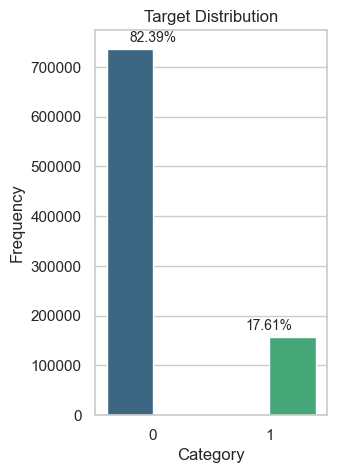

In [8]:
plt.figure(figsize=(3, 5))

plot_target(df_clean, 'Target Distribution')
plt.show()

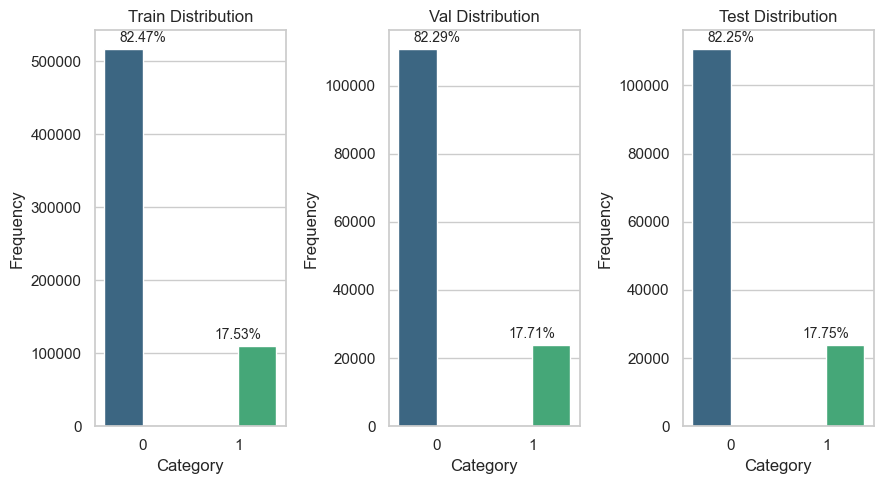

In [9]:
plt.figure(figsize=(9, 5))

plt.subplot(1, 3, 1)
plot_target(df_train, 'Train Distribution')

plt.subplot(1, 3, 2)
plot_target(df_val, 'Val Distribution')

plt.subplot(1, 3, 3)
plot_target(df_test, 'Test Distribution')

plt.tight_layout()
plt.show()

## Train Best Model

In [10]:
df_sample = df_train.sample(frac=0.1)

X_sample = df_sample.drop(target, axis=1)
y_sample = df_sample[target]

In [11]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'gamma': [0, 0.25, 0.5, 0.75],
    'max_depth': [3, 7, 10, 20],
    'n_estimators': [50, 100, 200, 300],
    'random_state': [rand_xgb]
}

In [11]:
grid_xgb = GridSearchCV(XGBClassifier(), param_grid, cv=5, scoring='roc_auc')
grid_xgb.fit(X_sample, y_sample)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0, 0.25, 0.5, 0.75],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 7, 10, 20],
                         'n_estimators': [50, 100, 200, 300],
                         'random_state': [44]},
             scoring='roc_auc')

In [12]:
# params = grid_xgb.best_params_
params = {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'random_state': 44}

print('Best Parameters: ', params)

Best Parameters:  {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'random_state': 44}


In [13]:
xgb_model = XGBClassifier(**params)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [14]:
val_acc = xgb_model.score(X_val, y_val)
print('Validation Accuracy: ', round(val_acc,4))

Validation Accuracy:  0.9537


## Metrics Analysis

In [15]:
y_pred = cross_val_predict(xgb_model, X_test, y_test, cv=10)

In [16]:
def plot_metric(metric, title):
    df_ = pd.DataFrame({'Class': range(len(metric)), 'Score': metric})

    plt.figure(figsize=(6, 2))
    sns.set(style='whitegrid')

    barplot = sns.barplot(data=df_, x='Score', y='Class', orient='h', palette='viridis', hue='Class')

    for index, value in enumerate(metric):
        barplot.text(value + 0.01, index, f'{value*100:.2f}%', ha='left', va='center')

    plt.title(title)
    plt.xlabel('Score')
    plt.ylabel('Class')
    plt.legend().remove()
    plt.show()

### Metrics Report

In [17]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9648    0.9752    0.9700    110629
           1     0.8791    0.8350    0.8565     23869

    accuracy                         0.9503    134498
   macro avg     0.9219    0.9051    0.9132    134498
weighted avg     0.9496    0.9503    0.9498    134498



### Confusion Matrix

In [18]:
xgb_matrix = confusion_matrix(y_test, y_pred, normalize='all')
xgb_matrix *= 100

xgb_matrix

array([[80.21457568,  2.03869203],
       [ 2.92792458, 14.81880771]])

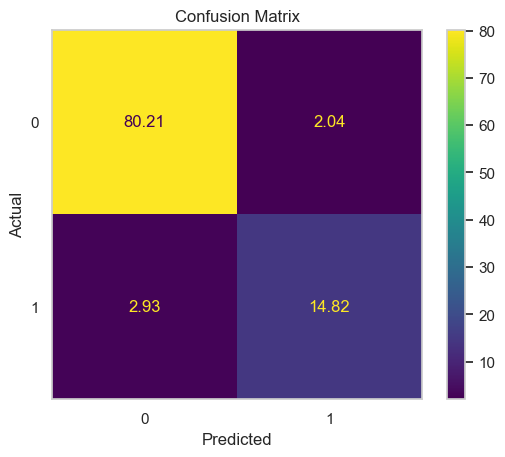

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_matrix,
                              display_labels=xgb_model.classes_)
disp.plot(cmap='viridis', values_format='.2f')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()

### Accuracy

La métrica de accuracy se define como la proporción de predicciones correctas respecto al total de predicciones realizadas. En el contexto de un modelo de clasificación binaria, se calcula utilizando la fórmula:

**Accuracy = Numero de predicciones correctas / Numero total de predicciones**

/Users/zorromac/Documents/Ly-Ax/TFMasterIA/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/zorromac/Documents/Ly-Ax/TFMasterIA/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


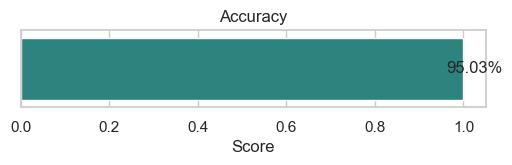

In [20]:
test_acc = accuracy_score(y_test, y_pred)

plt.figure(figsize=(6, 1))
sns.set(style='whitegrid')

sns.countplot(y=[test_acc], orient='h', palette='viridis', hue=[0])
plt.text(test_acc + 0.01, 0, f'{test_acc*100:.2f}%', ha='left', va='center')

plt.yticks([])
plt.title('Accuracy')
plt.xlabel('Score')
plt.legend().remove()
plt.show()

La interpretación de los resultados del accuracy es que el 95.03% de las predicciones realizadas por el modelo son correctas en relación con el conjunto total de predicciones. Es una métrica útil para evaluar el rendimiento general del modelo; sin embargo, el accuracy puede ser engañoso en situaciones de desbalance de clases, si la clase de interés (Default, Class = 1) es muy rara en comparación con la clase dominante (Pagado, Class = 0), el modelo podría alcanzar un alto accuracy simplemente prediciendo siempre la clase dominante. En esos casos, otras métricas como la Precisión, Recall, F1-Score, AUC-ROC, AUC-PR y la Matriz de Confusion podrían ser más informativas.

### Precision

La métrica de precision se define como la proporción de verdaderos positivos (instancias correctamente clasificadas como positivas) respecto al total de instancias clasificadas como positivas (verdaderos positivos más falsos positivos).

**Precision = Verdaderos Positivos / (Verdaderos Positivos + Falsos Positivos)​**

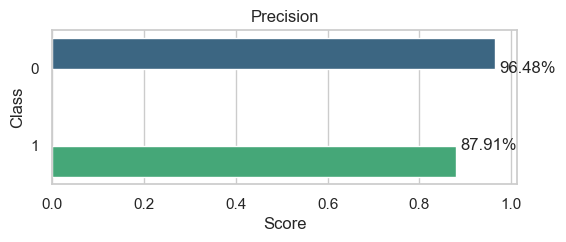

In [21]:
test_pre = precision_score(y_test, y_pred, average=None)

plot_metric(test_pre, 'Precision')

La interpretación de los resultados de precision es la siguiente:

- **La precision para Class = 0 (préstamos pagados)**: indica que del total de préstamos clasificados como pagados por el modelo (ya sea correctamente o incorrectamente), el 96.48% realmente fueron pagados.

- **La precision para Class = 1 (préstamos en default)**: indica que del total de préstamos clasificados como en default por el modelo (ya sea correctamente o incorrectamente), el 87.91% realmente entraron en default.


La precision es útil para evaluar cuántas de las instancias predichas como positivas son realmente positivas. Un valor alto de precision indica que el modelo tiene una baja tasa de falsos positivos en esa clase específica.

### Recall


La métrica de recall (sensibilidad o TPR) se define como la proporción de verdaderos positivos (instancias correctamente clasificadas como positivas) respecto al total de instancias que realmente son positivas (verdaderos positivos más falsos negativos).

**Recall = Verdaderos Positivos / (Verdaderos Positivos + Falsos Negativos)**

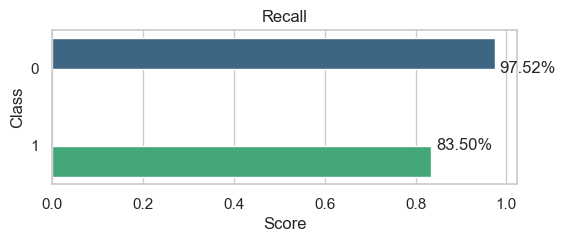

In [22]:
test_rec = recall_score(y_test, y_pred, average=None)

plot_metric(test_rec, 'Recall')

La interpretación de los resultados de recall es la siguiente:

- **El recall para Class = 0 (préstamos pagados)**: indica que del total de préstamos que realmente fueron pagados, el 97.52% fueron correctamente identificados por el modelo como pagados.

- **El recall para Class = 1 (préstamos en default)**: indica que del total de préstamos que realmente entraron en default, el 83.50% fueron correctamente identificados por el modelo como en default.

El recall es útil para evaluar cuántas de las instancias positivas reales fueron capturadas por el modelo. Un valor alto de recall indica que el modelo tiene una baja tasa de falsos negativos en esa clase específica.

### F1-Score


El F1-Score es una métrica que combina precision y recall, proporcionando una medida del equilibrio entre la precisión y la exhaustividad del modelo. Se calcula utilizando la siguiente fórmula:

**F1-Score = (2 × Precision × Recall) / (Precision + Recall)**

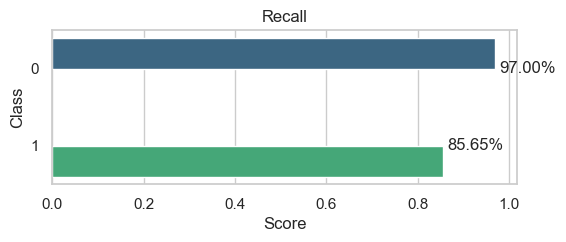

In [23]:
test_f1s = f1_score(y_test, y_pred, average=None)

plot_metric(test_f1s, 'Recall')

Para predecir si un préstamo bancario será pagado (Class = 0) o entrará en Default (Class = 1):

- **Para Class = 0 (préstamos pagados**): un F1-Score del 97.00% indica un equilibrio entre precision y recall para la clase pagado.

- **Para Class = 1 (préstamos en default)**: un F1-Score del 85.65% indica un equilibrio entre precision y recall para la clase en default.

Es una métrica que considera tanto la capacidad del modelo para identificar correctamente una clase como su capacidad para evitar clasificar incorrectamente esa clase. El F1-Score es una métrica útil cuando se busca un equilibrio entre la precisión y la exhaustividad, un F1-Score más alto indica un mejor rendimiento del modelo en términos de equilibrio entre precisión y exhaustividad.

### AUC-ROC

El Área Bajo la Curva ROC (AUC-ROC) es una métrica utilizada para evaluar el rendimiento de un modelo de clasificación, muestra la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos (especificidad) para diferentes umbrales de clasificación.

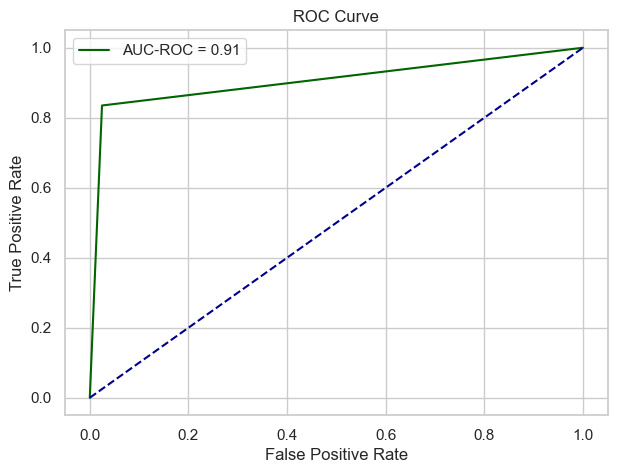

In [24]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
sns.set(style='whitegrid')

plt.plot(fpr, tpr, color='darkgreen', label='AUC-ROC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

La interpretación del resultado de AUC-ROC de 0.91 sugiere que el modelo tiene una buena capacidad para distinguir entre préstamos que serán pagados y préstamos que entrarán en default. La curva ROC asociada al modelo tiene un área sustancial bajo ella, lo que significa que la tasa de verdaderos positivos (TPR) es alta en comparación con la tasa de falsos positivos (FPR) en diversos umbrales de clasificación.

### AUC-PR

El Área Bajo la Curva de Precisión y Recall (AUC-PR) es una métrica utilizada para evaluar el rendimiento de un modelo de clasificación, mientras que AUC-ROC se enfoca en la TPR frente a la FPR, AUC-PR se centra en la precisión frente a recall (exhaustividad).

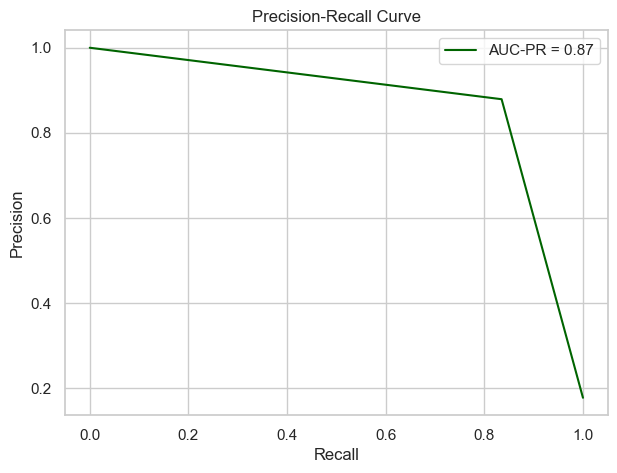

In [25]:
precision, recall, _  = precision_recall_curve(y_test, y_pred)
auc_pr = auc(recall, precision)

plt.figure(figsize=(7, 5))
sns.set(style='whitegrid')

plt.plot(recall, precision, color='darkgreen', label="AUC-PR = %0.2f" % auc_pr)

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

La interpretación del resultado de AUC-PR de 0.87 indica que el modelo tiene un área sustancial bajo ella, lo que significa que el modelo logra una buena precisión mientras mantiene un nivel significativo de exhaustividad. Ademas sugiere que el modelo es capaz de clasificar correctamente la mayoría de las instancias positivas y tiene una baja tasa de falsos positivos.